## Requirements 
* (done) Apply **mini-batch gradient descent** with appropriate batch size
* (tweak) Use appropriate **learning rate** (can be adaptive per epoch)
* (tweak) Apply **dropout** - find appropriate dropout rate at each layer
* (tweak) Initialize random **weights** properly before training
* (done) Do basic image **augmentation** of training data using Keras
* (done) Use **3 or more layers** with appropriate **number of neurons** per layer
* (done) Use **relu activation layer** in the right places
* (done) **Normalize and scale** the input before training with Keras
* (todo) Include **metrics**: testing, training accuracy validation curves and confusion matrix
* (todo) Display top common errors

In [587]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

In [588]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

## Load dataset

In [589]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [590]:
x_train.shape

(60000, 28, 28)

In [591]:
x_test.shape

(10000, 28, 28)

In [592]:
x_train = x_train[0:2000]
y_train = y_train[0:2000]

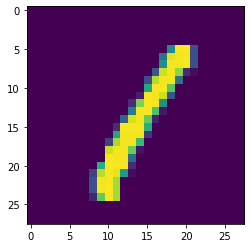

In [593]:
g = plt.imshow(x_train[3][:,:])

## Training dataset augmentation

Using Keras Datagen

In [594]:
x_train_augmented = x_train[0:500]
y_train_augmented = y_train[0:500]

In [595]:
x_train_augmented = x_train_augmented.reshape(-1,28,28,1)

In [596]:
x_train_augmented.shape

(500, 28, 28, 1)

In [597]:
# Augment 1k training dataset images
# Reference: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train_augmented)

In [598]:
# Use datagen.flow to obtain the entire batch at once and prepend to original dataset.
x_train2 = None
for x_batch, y_batch in datagen.flow(x_train_augmented, y_train_augmented, batch_size=len(x_train_augmented)):
    x_train2 = x_batch
    break

In [599]:
# Re-shape the augmented dataset into (num_instances, width, height)
x_train_augmented = x_train2.reshape(len(x_train_augmented), 28, 28)

In [600]:
x_train[0:500] = x_train_augmented

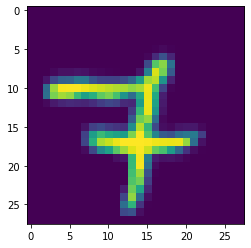

In [601]:
g = plt.imshow(x_train_augmented[3][:,:])

#### The above two images look the same..

In [602]:
np.array_equal(x_train_augmented[5], x_train[5])

False

#### Looks like Keras datagen actually did some augmentation. Not enough to be visible

## Scaling and Normalization
The training data is 1 3D array of (digit_label, pixel width, pixel height). For our MLP to run gradient descent, the width and height must be converted into a vector of 784 pixels.

This is accomplished using numpy's reshape() function.

In [603]:
num_pixels = x_train.shape[1] * x_train.shape[2]

# Scale input (examples, width, height) --> (examples, width*height)
x_train = x_train.reshape((x_train.shape[0], num_pixels)).astype('float32')
x_test = x_test.reshape((x_test.shape[0], num_pixels))

In [604]:
# Normalize pixel values from 0-255 to 0-1
x_train = x_train / 255
x_test = x_test / 255

## One hot encode the labels

One hot encoding essentially transforms the categorical values into a matrix where their existence or absence is marked by 1 or 0, respectively.

In [605]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

## Training functions

* Relu
* Mini-batch gradient descent based train()

In [606]:
def relu(x):
    return (x >= 0) * x

def relu2deriv(output):
    return output >= 0

In [607]:
'''
Runs a 3 layer mini batch gradient descent 

@ params: images
@ retval: void
''' 
def train(images, labels, test_images, test_labels):
    batch_size = 100

    alpha, iterations = (0.0009, 64)
    
    # MNIST dataset specific settings and hidden layer neuron size
    pixels_per_image, num_labels, hidden_size = (784, 10, 100)

    # Weight initialization for various layers -- # of neurons based on the tuple passed to np.random
    weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size*2)) - 0.1
    weights_1_2 = 0.2 * np.random.random((hidden_size*2, hidden_size)) - 0.1
    weights_2_3 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1
    
    for j in range(iterations):
        error, correct_cnt = (0.0, 0)
      
        for i in range(int(len(images) / batch_size)):
            batch_start, batch_end = ((i * batch_size), ((i+1) * batch_size))

            layer_0 = images[batch_start:batch_end]
            
            layer_1 = relu(np.dot(layer_0, weights_0_1))
            l1_dropout_mask = np.random.randint(2, size=layer_1.shape)
            layer_1 *= l1_dropout_mask * 2
            
            layer_2 = relu(np.dot(layer_1, weights_1_2))
            l2_dropout_mask = np.random.randint(2, size=layer_2.shape)
            layer_2 *= l2_dropout_mask * 2
            
            layer_3 = np.dot(layer_2, weights_2_3)

            error += np.sum((labels[batch_start:batch_end] - layer_3) ** 2)
            for k in range(batch_size):
                correct_cnt += int(np.argmax(layer_2[k:k+1])) == np.argmax(labels[batch_start+k:batch_start+k+1])

                layer_3_delta = (labels[batch_start:batch_end] - layer_3) / batch_size
                layer_2_delta = layer_3_delta.dot(weights_2_3.T) * relu2deriv(layer_2)
                layer_2_delta *= l2_dropout_mask
                layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
                layer_1_delta *= l1_dropout_mask

                weights_2_3 += alpha * layer_2.T.dot(layer_3_delta)
                weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
                weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)

        if(j%10 == 0):
            test_error = 0.0
            test_correct_cnt = 0

            for i in range(len(test_images)):
                layer_0 = test_images[i:i+1]
                layer_1 = relu(np.dot(layer_0,weights_0_1))
                layer_2 = relu(np.dot(layer_1, weights_1_2))
                layer_3 = relu(np.dot(layer_2, weights_2_3))

                test_error += np.sum((test_labels[i:i+1] - layer_3) ** 2)
                test_correct_cnt += int(np.argmax(layer_3) == \
                                         np.argmax(test_labels[i:i+1]))

            sys.stdout.write("\n" + \
            "I:" + str(j) + \
            " Test-Err:" + str(test_error/ float(len(test_images)))[0:5] +\
            " Test-Acc:" + str(test_correct_cnt/ float(len(test_images)))+\
            " Train-Err:" + str(error/ float(len(images)))[0:5] +\
            " Train-Acc:" + str(correct_cnt/ float(len(images))))


In [ ]:
train(x_train, y_train, x_test, y_test)


I:0 Test-Err:0.876 Test-Acc:0.2221 Train-Err:1.176 Train-Acc:0.013
I:10 Test-Err:0.732 Test-Acc:0.6997 Train-Err:0.820 Train-Acc:0.0085
I:20 Test-Err:0.637 Test-Acc:0.7616 Train-Err:0.758 Train-Acc:0.011
I:30 Test-Err:0.581 Test-Acc:0.798 Train-Err:0.724 Train-Acc:0.0085
I:40 Test-Err:0.555 Test-Acc:0.8079 Train-Err:0.696 Train-Acc:0.0045

## Metrics

### Training

### Testing

### Confusion matrix

### Most common errors